In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, track_plots, plot
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
#from vessel_manoeuvring_models.models.vmm_martin_simple import martins_simple_model as vmm
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='wPCC'
time_series = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
model_loader = catalog.load(f"{ship}.models")
#time_series_meta_data.rename(columns={'test_type':'test type'}, inplace=True)

[05/15/23 09:22:25] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=919208;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=165263;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/15/23 09:22:25] INFO     Kedro project phd                                                      ]8;id=310748;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=842954;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=636377;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=192169;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=952959;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=516422;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=429011;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=26341;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:wPCC.exclude_parameters'                 ]8;id=666058;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=221090;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=392593;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=215713;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=592463;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=446975;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
model = model_loader["wpcc.updated.vmm_martins_simple.joined.model"]()

## MDL

In [6]:
time_series

{'wpcc.updated.22611.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fd9988c8490>>,
 'wpcc.updated.22612.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fd965b0eda0>>,
 'wpcc.updated.22613.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fd965b0f340>>,
 'wpcc.updated.22614.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fd965b0f580>>,
 'wpcc.updated.22615.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fd96262f460>>,
 'wpcc.updated.22616.ek_smooth': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pandas.csv_dataset.CSVDataSet object at 0x7fd9590c4100>>,
 'wpcc.updated.22635.ek_smooth': <

In [7]:
data = time_series['wpcc.updated.22774.ek_smooth']()

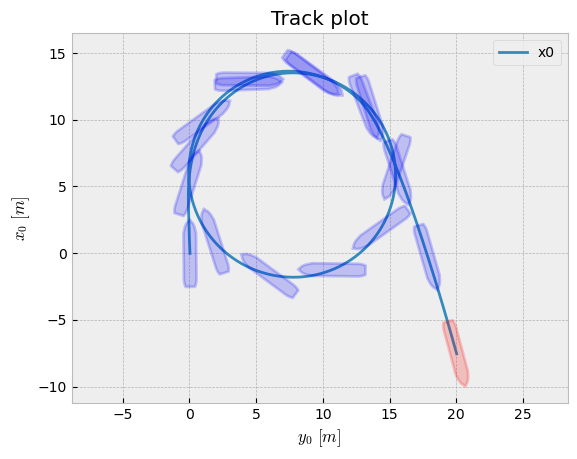

In [8]:
track_plot(df=data, lpp=ship_data['L'], beam=ship_data['B']);

In [9]:
result = model.simulate(data)

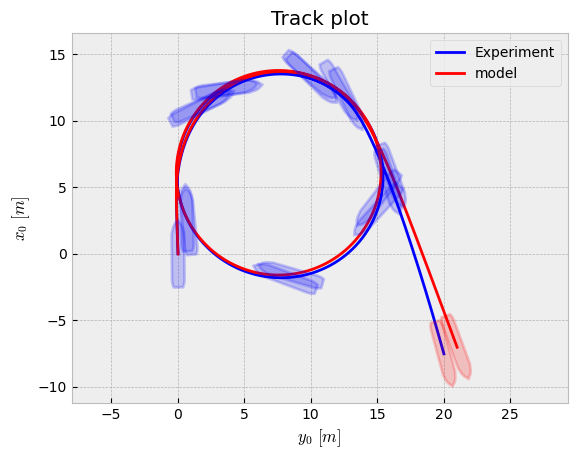

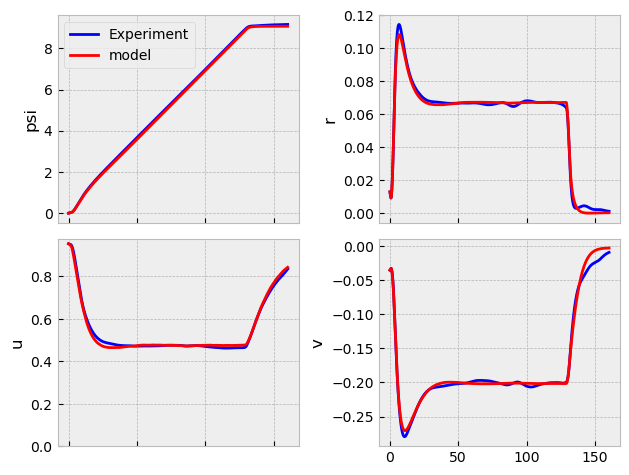

In [10]:
dataframes = {
'Experiment':data.rolling(5).mean(),
'model' : result.result
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
plot(dataframes, keys=['u','v','r','psi'], time_window=time_window);

## Inverse dynamics regression

In [11]:
added_masses = extract_added_masses(parameters=model.parameters)

In [12]:
data_all_MDL = time_series['wpcc.updated.joined.ek_smooth']()

In [13]:
#data_with_force = predict_force(data=data.rolling(window=2).mean().dropna(), added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)
data_with_force = predict_force(data=data_all_MDL, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

#data_with_force = predict_force(data=data_ek, added_masses=added_masses, ship_parameters=ship_data, vmm=vmm)

In [14]:
from vmm_abkowitz_diminished import vmm as vmm
regression, derivatives = fit_motions(data=data_with_force, added_masses=added_masses, ship_data=ship_data, vmm=vmm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fx   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                          8.577e+04
Date:                Mon, 15 May 2023   Prob (F-statistic):                        0.00
Time:                        09:22:35   Log-Likelihood:                      6.9157e+05
No. Observations:               96500   AIC:                                 -1.383e+06
Df Residuals:                   96487   BIC:                                 -1.383e+06
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Xu              12.7368      0.066    194.055      0.000      12.608      12.865
Xdeltadelta     -0.0245      0.009     -2.701      0.007      -0.042      -0.007
Xrr             -2.6532      0.023   -115.809      0.000      -2.698      -2.608
Xuu            -12.7368      0.066   -194.054      0.000     -12.865     -12.608
Xvv             -6.2368      0.033   -191.244      0.000      -6.301      -6.173
Xrdelta         -1.9379      0.029    -67.758      0.000      -1.994      -1.882
Xvdelta         -3.0319      0.023   -129.772      0.000      -3.078      -2.986
Xvr             -6.1952      0.037   -167.965      0.000      -6.267      -6.123
Xudeltadelta     0.0317      0.009      3.491      0.000       0.014       0.050
Xurr             2.7232      0.023    118.250      0.000       2.678       2.768
Xurdelta         1.9962      0.029     69.555      0.000       1.940       2.052
Xuvdelta         3.1171      0.023    133.008      0.000       3.071       3.163
Xuvr             6.3840      0.037    171.973      0.000       6.311       6.457
==============================================================================
Omnibus:                    17467.667   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           451752.017
Skew:                          -0.103   Prob(JB):                         0.00
Kurtosis:                      13.598   Cond. No.                     2.75e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     fy   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          6.950e+06
Date:                Mon, 15 May 2023   Prob (F-statistic):                        0.00
Time:                        09:22:35   Log-Likelihood:                      7.0776e+05
No. Observations:               96500   AIC:                                 -1.416e+06
Df Residuals:                   96492   BIC:                                 -1.415e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Yuur           0.3508      0.022     15.710      0.000       0.307       0.395
Yuv           -2.0673      0.071    -29.250      0.000      -2.206      -1.929
Yvvv          -0.1485      0.001   -128.675      0.000      -0.151      -0.146
Yur           -0.5852      0.044    -13.202      0.000      -0.672      -0.498
Yvvr          -0.1161      0.002    -74.435      0.000      -0.119      -0.113
Yuuv           1.0996      0.036     30.862      0.000       1.030       1.169
Yrrr           0.0018      0.000      6.773      0.000       0.001       0.002
Yv             0.9511      0.035     27.128      0.000       0.882       1.020
Yr             0.2348      0.022     10.660      0.000       0.192       0.278
Yvrr          -0.0488      0.001    -37.031      0.000      -0.051      -0.046
==============================================================================
Omnibus:                    16515.434   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           380102.254
Skew:                          -0.047   Prob(JB):                         0.00
Kurtosis:                      12.722   Cond. No.                     6.80e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 6.11e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     mz   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          7.235e+05
Date:                Mon, 15 May 2023   Prob (F-statistic):                        0.00
Time:                        09:22:35   Log-Likelihood:                      9.2316e+05
No. Observations:               96500   AIC:                                 -1.846e+06
Df Residuals:                   96484   BIC:                                 -1.846e+06
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Ndelta               0.0589      0.004     15.174      0.000       0.051       0.066
Nr                   0.0345      0.005      6.473      0.000       0.024       0.045
Nv                  -0.2274      0.005    -48.589      0.000      -0.237      -0.218
Ndeltadeltadelta     0.0026   4.64e-05     55.439      0.000       0.002       0.003
Nrrr                -0.0063      0.000    -21.415      0.000      -0.007      -0.006
Nvvv                 0.0249      0.000     95.381      0.000       0.024       0.025
Nudelta             -0.1307      0.008    -16.312      0.000      -0.146      -0.115
Nrrdelta             0.0018      0.000      4.039      0.000       0.001       0.003
Nuudelta             0.0697      0.004     16.835      0.000       0.062       0.078
Nvvdelta            -0.0108      0.000    -25.928      0.000      -0.012      -0.010
Nur                 -0.0742      0.011     -6.834      0.000      -0.096      -0.053
Nrdeltadelta         0.0097      0.000     40.838      0.000       0.009       0.010
Nuur                 0.0374      0.006      6.741      0.000       0.027       0.048
Nvvr                -0.0029      0.001     -4.014      0.000      -0.004      -0.001
Nuv                  0.4787      0.009     50.781      0.000       0.460       0.497
Nvdeltadelta         0.0111      0.000     39.222      0.000       0.011       0.012
Nvrr                -0.0128      0.001    -13.391      0.000      -0.015      -0.011
Nuuv                -0.2523      0.005    -53.116      0.000      -0.262      -0.243
Nvrdelta             0.0026      0.001      2.629      0.009       0.001       0.005
==============================================================================
Omnibus:                    24587.178   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           685336.498
Skew:                           0.625   Prob(JB):                         0.00
Kurtosis:                      15.996   Cond. No.                     4.54e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 2.38e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

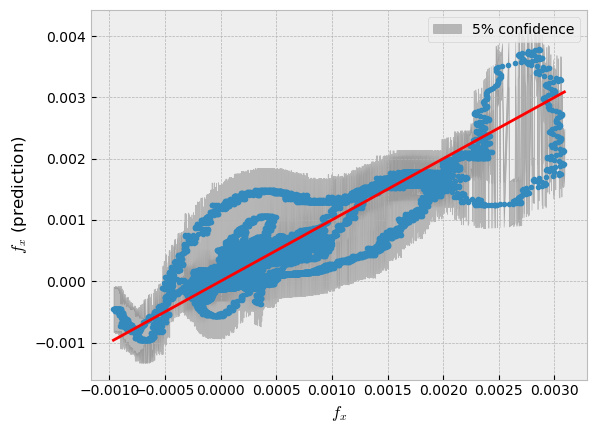

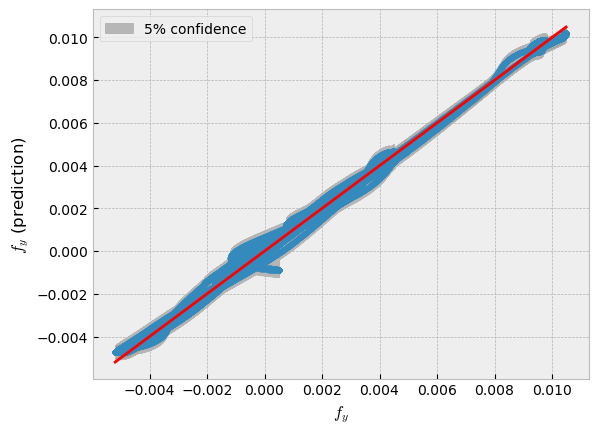

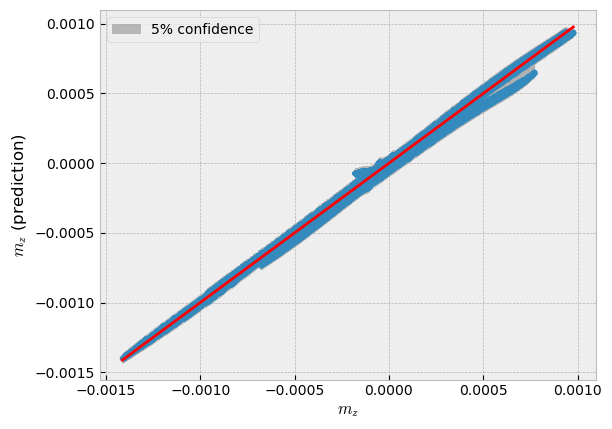

In [15]:
regression.show()

In [19]:
model_no_thrust = create_model_from_motion_regression(regression=regression)
model_no_thrust.control_keys = ['delta']

In [20]:
result_no_thrust = model_no_thrust.simulate(data)

In [21]:
data['beta'] = -np.arctan2(data['v'],data['u'])

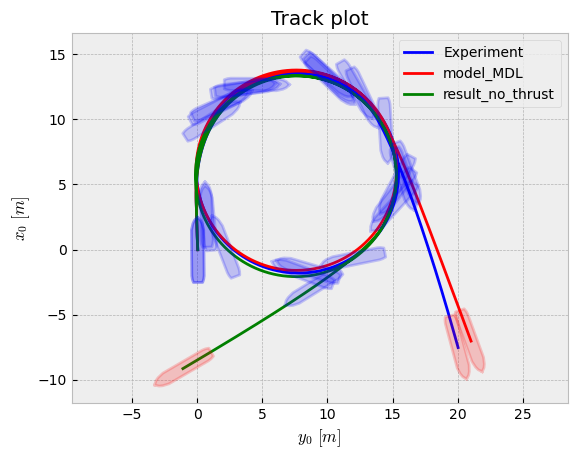

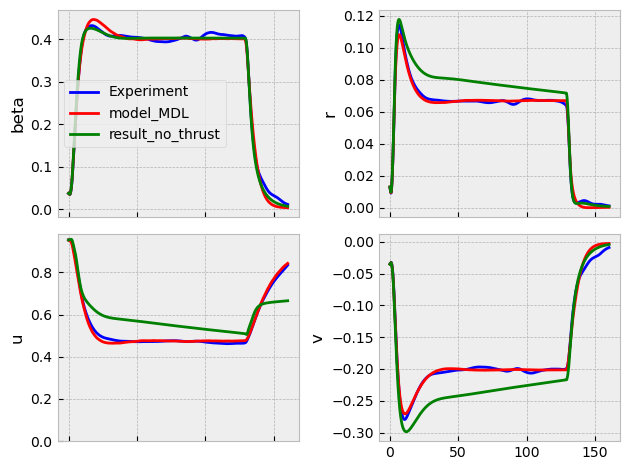

In [22]:
dataframes = {
'Experiment':data.rolling(5).mean(),
'model_MDL' : result.result,
'result_no_thrust': result_no_thrust.result,
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
plot(dataframes, keys=['u','v','r','beta'], time_window=time_window);

In [23]:
data2 = time_series['wpcc.updated.22773.ek_smooth']()
result2_no_thrust = model_no_thrust.simulate(data2)
result2 = model.simulate(data2)

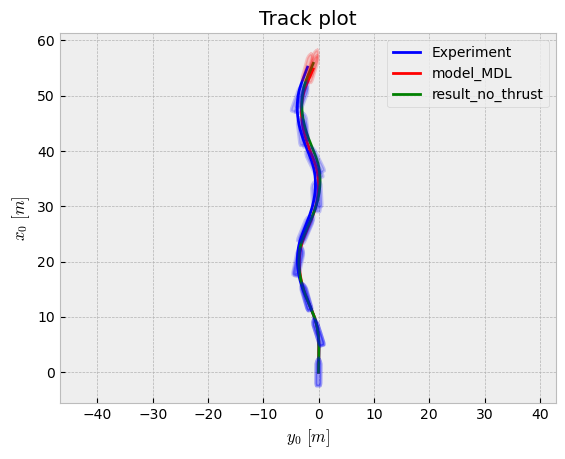

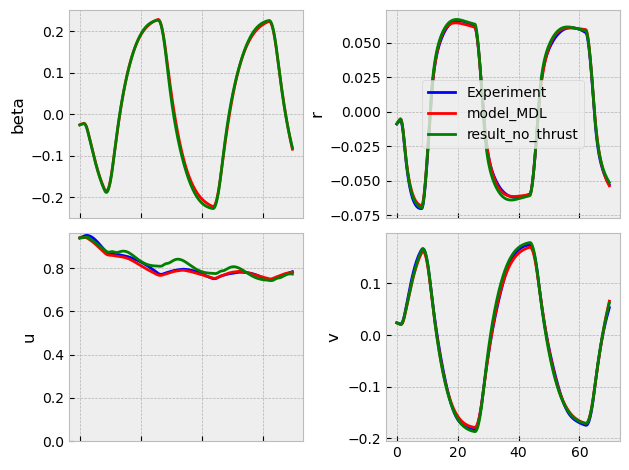

In [24]:
dataframes = {
'Experiment':data2.rolling(5).mean(),
'model_MDL' : result2.result,
'result_no_thrust': result2_no_thrust.result,
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
plot(dataframes, keys=['u','v','r','beta'], time_window=time_window);

In [25]:
models = {key:loader for key,loader in model_loader.items()}
models["vmm_abkowitz_diminished"] = model_no_thrust
catalog.save(f"{ship}.models",models)

[05/15/23 09:24:34] INFO     Saving data to 'wPCC.models' (PartitionedDataSet)...               ]8;id=257913;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=393520;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [26]:
models

{'vmm_abkowitz_diminished': <vessel_manoeuvring_models.models.vmm.ModelSimulator at 0x7fd964015120>,
 'wpcc.updated.vmm_martins_simple.joined.model': <bound method AbstractVersionedDataSet.load of <kedro.extras.datasets.pickle.pickle_dataset.PickleDataSet object at 0x7fd9590e4bb0>>}